In [ ]:
# !cp /kaggle/input/data-bowl-2019-external-data/*.py /kaggle/working

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
import jupytools.syspath
def ignore(*args, **kwargs): pass
warnings.warn = ignore
jupytools.syspath.add('..')

In [30]:
from collections import Counter, OrderedDict
from functools import partial

import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.metrics import cohen_kappa_score
from tqdm.auto import tqdm

import bundle
import features as F
import selection
import utils as U
from dataset import load, load_sample, Subset
from encode import encode
from training import train, inference, submit
from meta import compute_meta_data
from metric import optimize_rounding_bounds, RegressionCappa

In [3]:
sample = False
if U.on_kaggle():
    U.log('Loading test set only.')
    tst_data = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
else:
    if sample:
        U.log('Warning: loading train and test data sample.')
        trn_data, _, _ = load_sample(Subset.Train, 500_000)
        [tst_data] = load_sample(Subset.Test, 500_000)
    else:
        U.log('Loading train and test.')
        trn_data, trn_spec, trn_targ = load(Subset.Train)
        [tst_data] = load(Subset.Test)

Loading train and test.
(11341042, 11) (17690, 7) (386, 3) (1156414, 11) 

## Preparing

In [4]:
transform = U.combine(
    partial(F.add_feature_combinations, pairs=[('title', 'event_code')]),
    partial(F.add_datetime, column='timestamp', prefix='ts'),
)

if U.on_kaggle():
    U.log('Transforming test data only.')
    X_tst = transform(tst_data.copy())
    U.log(X_tst.shape)
else:
    U.log('Transforming train and test data.')
    X_tst = transform(tst_data.copy())
    X_trn = transform(trn_data.copy())
    U.log(X_trn.shape, X_tst.shape)

Transforming train and test data.
(11341042, 19) (1156414, 19)


In [5]:
if U.on_kaggle():
    U.log('Reading pre-computed meta from disk.')
    meta = bundle.meta()
else:
    U.log('Computing meta using train and test datasets.')
    meta = compute_meta_data(X_trn, X_tst)
    U.log('Saving computed meta on disk.')
    bundle.save_meta(meta, 'meta')

Computing meta using train and test datasets.
Saving computed meta on disk.


In [6]:
extractor = F.FeaturesExtractor([
    F.CountingFeatures(meta),
    F.PerformanceFeatures(meta),
    F.VarietyFeatures(meta),
    F.EventDataFeatures(meta)
])

algo = F.InMemoryAlgorithm(extractor, meta, num_workers=12)

cat_cols = ['session_title']

if U.on_kaggle():
    U.log('Preparing test dataset.')
    X_tst = algo.run(X_tst, test=True)
    encoders = bundle.encoders()
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
else:
    U.log('Preparing train and test datasets.')
    X_trn = algo.run(X_trn)
    X_tst = algo.run(X_tst, test=True)
    X_trn, encoders = encode(X_trn, cat_cols)
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
    bundle.save(encoders, 'encoders')

Preparing train and test datasets.
Running algorithm in train mode.



Running algorithm in test mode.


In [10]:
if U.on_kaggle():
    U.log('Running post-processing on test set only.')
    F.add_user_wise_features(X_tst, meta)
else:
    U.log('Running post-processing on train and test sets.')
    F.add_user_wise_features(X_trn, meta)
    F.add_user_wise_features(X_tst, meta)

Running post-processing on train and test sets.


In [40]:
if not U.on_kaggle():
    class PredictionsRoudner:
        def __init__(self, train_target):
            dist = Counter(train_target)
            size = len(train_target)
            for k in dist:
                dist[k] /= size
            self.dist = dist
        def __call__(self, y_pred):
            acc, bounds = 0, []
            for i in range(3):
                acc += self.dist[i]
                perc = np.percentile(y_pred, acc*100)
                bounds.append(perc)
            rounded = pd.cut(y_pred, [-np.inf] + sorted(bounds) + [np.inf], labels=[0, 1, 2, 3])
            return rounded.tolist(), bounds

    ROUNDER = PredictionsRoudner(X_trn['accuracy_group']) 

    def cappa(y_true, y_pred):
        y_pred_rounded, _ = ROUNDER(y_pred)
        score = cohen_kappa_score(y_true, y_pred_rounded, weights='quadratic')
        return score

## Experiments

In [41]:
def normalize(dataset, columns):
    def _normalize(x): return U.savediv(x, x.max())
    groups = dataset.groupby('installation_id')
    for column in tqdm(columns):
        dataset[column] = groups[column].transform(_normalize)

In [32]:
cnt_cols = U.starts_with(X_trn.columns, 'cnt_')
normalize(X_trn, cnt_cols)

In [42]:
features = [c for c in X_trn.columns 
            if c not in ('installation_id', 'game_session', 'accuracy_group')]

In [43]:
from sklearn.model_selection import GroupKFold
from training import EnsembleTrainer, get_default_config
model_type = 'lightgbm'
trainer = EnsembleTrainer(algo=model_type, cv_metrics={'cappa': cappa})
fold = GroupKFold(n_splits=5)
config = get_default_config(model_type)
result = trainer.train(X_trn, features=features, fold=fold, config=config)

Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.02701	val's rmse: 1.04051
[200]	trn's rmse: 0.946276	val's rmse: 0.976166
[300]	trn's rmse: 0.902011	val's rmse: 0.948863
[400]	trn's rmse: 0.872618	val's rmse: 0.935441
[500]	trn's rmse: 0.849223	val's rmse: 0.927881
[600]	trn's rmse: 0.829252	val's rmse: 0.923344
[700]	trn's rmse: 0.811843	val's rmse: 0.920656
[800]	trn's rmse: 0.795787	val's rmse: 0.919243
[900]	trn's rmse: 0.780755	val's rmse: 0.918034
[1000]	trn's rmse: 0.766659	val's rmse: 0.917058
[1100]	trn's rmse: 0.753145	val's rmse: 0.916599
[1200]	trn's rmse: 0.740445	val's rmse: 0.916496
Early stopping, best iteration is:
[1154]	trn's rmse: 0.746188	val's rmse: 0.916384
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.02539	val's rmse: 1.05272
[200]	trn's rmse: 0.944984	val's rmse: 0.987091
[300]	trn's rmse: 0.90147	val's rmse: 0.959097
[400]	trn's rmse: 0.871997	v

In [ ]:
# features from event_data
# https://www.kaggle.com/c/data-science-bowl-2019/discussion/124028

# truncated validation
# https://www.kaggle.com/ragnar123/truncated-val
# https://www.kaggle.com/c/data-science-bowl-2019/discussion/120790

# params = {'boosting_type': 'gbdt', 
#           'metric': 'rmse', 
#           'objective': 'regression', 
#           'eval_metric': 'cappa', 
#           'n_jobs': -1, 
#           'seed': 42, 
#           'num_leaves': 26, 
#           'learning_rate': 0.077439684887749, 
#           'max_depth': 33, 
#           'lambda_l1': 3.27791989030057, 
#           'lambda_l2': 1.3047627805931334, 
#           'bagging_fraction': 0.896924978584253, 
#           'bagging_freq': 1, 
#           'colsample_bytree': 0.8710772167017853}

In [45]:
columns = X_trn.columns.tolist()
cnt_cols = U.starts_with(columns, 'cnt_')
perf_cols = U.starts_with(columns, 'perf_')
var_cols = U.starts_with(columns, 'var_')
user_cols = U.starts_with(columns, 'user_')
event_cols = U.starts_with(columns, 'event_')
cat_cols = ['session_title']
cols = cnt_cols + perf_cols + var_cols + user_cols + event_cols + cat_cols

features_groups = [
    ('cnt+perf+var', cnt_cols + perf_cols + var_cols),
    ('cnt+perf+user', cnt_cols + perf_cols + user_cols),
    ('cnt+perf+cat', cnt_cols + perf_cols + cat_cols),
    ('cnt+perf+var+user+cat', cnt_cols + perf_cols + var_cols + user_cols + cat_cols),
    ('event+cnt+perf', event_cols + cnt_cols + perf_cols),
    ('event+cnt+perf+user', event_cols + cnt_cols + perf_cols + user_cols),
    ('event+cnt+perf+var', event_cols + cnt_cols + perf_cols + var_cols),
    ('event+cnt+pert+cat', event_cols + cnt_cols + perf_cols + cat_cols),
    ('event+cnt+perf+user+var+cat', 
     event_cols + cnt_cols + perf_cols + user_cols + var_cols + cat_cols),
    ('all', cols),
    ('all-event', [c for c in cols if c not in event_cols])
]

In [46]:
from sklearn.model_selection import GroupKFold
from training import EnsembleTrainer, get_default_config

model_type = 'lightgbm'
trainer = EnsembleTrainer(algo=model_type, cv_metrics={'cappa': cappa})
fold = GroupKFold(n_splits=5)
config = get_default_config(model_type)
U.set_nested(config, 'model_params.feature_fraction', 0.8)
U.set_nested(config, 'model_params.bagging_fraction', 0.75)
U.set_nested(config, 'model_params.bagging_freq', 1)

results = []
for col_group, features in features_groups:
    U.log(f'Training columns group: {col_group}')
    result = trainer.train(X_trn, features=features, fold=fold, config=config)
    results.append((col_group, result))

Training columns group: cnt+perf+var
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.12881	val's rmse: 1.15177
[200]	trn's rmse: 1.06731	val's rmse: 1.11233
[300]	trn's rmse: 1.02757	val's rmse: 1.09167
[400]	trn's rmse: 0.999488	val's rmse: 1.08214
[500]	trn's rmse: 0.976989	val's rmse: 1.07608
[600]	trn's rmse: 0.957627	val's rmse: 1.07282
[700]	trn's rmse: 0.940116	val's rmse: 1.07049
[800]	trn's rmse: 0.92396	val's rmse: 1.06874
[900]	trn's rmse: 0.909222	val's rmse: 1.06814
Early stopping, best iteration is:
[895]	trn's rmse: 0.909912	val's rmse: 1.06796
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.12233	val's rmse: 1.16087
[200]	trn's rmse: 1.06089	val's rmse: 1.12064
[300]	trn's rmse: 1.02243	val's rmse: 1.10129
[400]	trn's rmse: 0.994791	val's rmse: 1.09189
[500]	trn's rmse: 0.972486	val's rmse: 1.08591
[600]	trn's rmse: 0.953331	val's rmse: 1.08261
[700]	trn's r

[500]	trn's rmse: 0.859124	val's rmse: 0.930452
[600]	trn's rmse: 0.840978	val's rmse: 0.927062
[700]	trn's rmse: 0.825044	val's rmse: 0.924634
[800]	trn's rmse: 0.810307	val's rmse: 0.923102
[900]	trn's rmse: 0.796331	val's rmse: 0.921964
[1000]	trn's rmse: 0.783201	val's rmse: 0.921499
[1100]	trn's rmse: 0.771164	val's rmse: 0.921093
Early stopping, best iteration is:
[1086]	trn's rmse: 0.772855	val's rmse: 0.92103
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.03246	val's rmse: 1.05921
[200]	trn's rmse: 0.9518	val's rmse: 0.992251
[300]	trn's rmse: 0.909512	val's rmse: 0.96428
[400]	trn's rmse: 0.880949	val's rmse: 0.950702
[500]	trn's rmse: 0.859173	val's rmse: 0.942565
[600]	trn's rmse: 0.841518	val's rmse: 0.938025
[700]	trn's rmse: 0.825736	val's rmse: 0.935061
[800]	trn's rmse: 0.811351	val's rmse: 0.933029
[900]	trn's rmse: 0.797813	val's rmse: 0.93107
[1000]	trn's rmse: 0.785008	val's rmse: 0.929617
[1100]	trn's rmse: 

Fold evaluation results:
cv_cappa_1=0.6614, cv_cappa_2=0.6628, cv_cappa_3=0.6561, cv_cappa_4=0.6380, cv_cappa_5=0.6401
Training columns group: event+cnt+perf
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.12566	val's rmse: 1.1534
[200]	trn's rmse: 1.06016	val's rmse: 1.11069
[300]	trn's rmse: 1.01743	val's rmse: 1.08787
[400]	trn's rmse: 0.986863	val's rmse: 1.07668
[500]	trn's rmse: 0.962013	val's rmse: 1.06978
[600]	trn's rmse: 0.940832	val's rmse: 1.06519
[700]	trn's rmse: 0.921858	val's rmse: 1.06269
[800]	trn's rmse: 0.904435	val's rmse: 1.06081
[900]	trn's rmse: 0.888287	val's rmse: 1.05956
[1000]	trn's rmse: 0.873062	val's rmse: 1.05907
[1100]	trn's rmse: 0.858469	val's rmse: 1.05875
[1200]	trn's rmse: 0.84473	val's rmse: 1.05895
Early stopping, best iteration is:
[1132]	trn's rmse: 0.854018	val's rmse: 1.05841
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.12035	v

[1500]	trn's rmse: 0.795252	val's rmse: 1.04237
[1600]	trn's rmse: 0.783718	val's rmse: 1.04174
[1700]	trn's rmse: 0.772428	val's rmse: 1.04144
[1800]	trn's rmse: 0.76155	val's rmse: 1.04113
[1900]	trn's rmse: 0.750956	val's rmse: 1.04124
[2000]	trn's rmse: 0.740577	val's rmse: 1.0412
Early stopping, best iteration is:
[1953]	trn's rmse: 0.745431	val's rmse: 1.041
Running k-fold 5 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.11492	val's rmse: 1.16086
[200]	trn's rmse: 1.04819	val's rmse: 1.11929
[300]	trn's rmse: 1.00557	val's rmse: 1.0968
[400]	trn's rmse: 0.973297	val's rmse: 1.0835
[500]	trn's rmse: 0.947806	val's rmse: 1.07622
[600]	trn's rmse: 0.926128	val's rmse: 1.07136
[700]	trn's rmse: 0.907043	val's rmse: 1.06796
[800]	trn's rmse: 0.88991	val's rmse: 1.06582
[900]	trn's rmse: 0.873481	val's rmse: 1.06392
[1000]	trn's rmse: 0.858374	val's rmse: 1.06294
[1100]	trn's rmse: 0.84394	val's rmse: 1.06191
[1200]	trn's rmse: 0.83019	val's rms

[300]	trn's rmse: 0.909374	val's rmse: 0.947187
[400]	trn's rmse: 0.880077	val's rmse: 0.934728
[500]	trn's rmse: 0.857455	val's rmse: 0.928463
[600]	trn's rmse: 0.83875	val's rmse: 0.925012
[700]	trn's rmse: 0.822071	val's rmse: 0.9224
[800]	trn's rmse: 0.806903	val's rmse: 0.921434
[900]	trn's rmse: 0.792565	val's rmse: 0.920334
[1000]	trn's rmse: 0.778731	val's rmse: 0.919214
[1100]	trn's rmse: 0.766105	val's rmse: 0.91882
[1200]	trn's rmse: 0.753544	val's rmse: 0.918027
[1300]	trn's rmse: 0.741967	val's rmse: 0.91818
Early stopping, best iteration is:
[1213]	trn's rmse: 0.752065	val's rmse: 0.917984
Running k-fold 4 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.02495	val's rmse: 1.05449
[200]	trn's rmse: 0.945879	val's rmse: 0.993688
[300]	trn's rmse: 0.902135	val's rmse: 0.966445
[400]	trn's rmse: 0.873364	val's rmse: 0.953558
[500]	trn's rmse: 0.850491	val's rmse: 0.946531
[600]	trn's rmse: 0.831666	val's rmse: 0.942683
[700]	trn's rmse: 

[1100]	trn's rmse: 0.75449	val's rmse: 0.916562
Early stopping, best iteration is:
[1080]	trn's rmse: 0.757126	val's rmse: 0.916394
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.0281	val's rmse: 1.05551
[200]	trn's rmse: 0.946295	val's rmse: 0.988806
[300]	trn's rmse: 0.902454	val's rmse: 0.960313
[400]	trn's rmse: 0.873147	val's rmse: 0.94663
[500]	trn's rmse: 0.850798	val's rmse: 0.939377
[600]	trn's rmse: 0.83156	val's rmse: 0.934885
[700]	trn's rmse: 0.814434	val's rmse: 0.931345
[800]	trn's rmse: 0.798747	val's rmse: 0.929161
[900]	trn's rmse: 0.784222	val's rmse: 0.927437
[1000]	trn's rmse: 0.7704	val's rmse: 0.925842
[1100]	trn's rmse: 0.757698	val's rmse: 0.924777
[1200]	trn's rmse: 0.745715	val's rmse: 0.924339
[1300]	trn's rmse: 0.733986	val's rmse: 0.92376
[1400]	trn's rmse: 0.722675	val's rmse: 0.923167
[1500]	trn's rmse: 0.711779	val's rmse: 0.9227
[1600]	trn's rmse: 0.701416	val's rmse: 0.922447
Early stopping, be

In [48]:
report = pd.DataFrame([
    OrderedDict([('features', name)] + list(result.cv.items())) 
    for name, result in results])
cappa_cols = U.starts_with(report.columns, 'cv_cappa')
report['mean'] = report[cappa_cols].mean(axis=1)
report['std'] = report[cappa_cols].std(axis=1)
report.sort_values(by=['mean'], inplace=True, ascending=False)
report.reset_index(drop=True, inplace=True)
report.to_csv(f'report_{U.now()}.csv', index=False)

In [49]:
def highlight_best(col):
    if not col.name.startswith('cv_cappa_'):
        return [''] * len(col)
    is_best = col.index == col.argmax()
    return ['background-color: salmon' if idx else '' for idx in is_best]

In [50]:
report.style.apply(highlight_best)

,features,cv_cappa_1,cv_cappa_2,cv_cappa_3,cv_cappa_4,cv_cappa_5,mean,std
0,event+cnt+perf+user+var+cat,0.66341,0.660157,0.653047,0.641571,0.642438,0.652124,0.00997425
1,cnt+perf+var+user+cat,0.661447,0.662829,0.656141,0.63801,0.640121,0.65171,0.0118327
2,all-event,0.661447,0.662829,0.656141,0.63801,0.640121,0.65171,0.0118327
3,all,0.659128,0.661582,0.650498,0.644241,0.639052,0.6509,0.00957444
4,event+cnt+pert+cat,0.65431,0.651608,0.642671,0.640503,0.631568,0.644132,0.00911939
5,cnt+perf+cat,0.6577,0.652855,0.642489,0.632136,0.63032,0.6431,0.0121678
6,event+cnt+perf+user,0.521208,0.512857,0.527262,0.524794,0.511281,0.519481,0.00712177
7,event+cnt+perf,0.509611,0.504841,0.514338,0.513757,0.497203,0.50795,0.0071141
8,event+cnt+perf+var,0.508719,0.503773,0.512882,0.507527,0.492748,0.50513,0.00764626
9,cnt+perf+user,0.517462,0.482577,0.508359,0.516605,0.496669,0.504334,0.0147584


In [151]:
import json
sample = trn_data.sample(1_000_000)
event_data = pd.io.json.json_normalize(sample.event_data.apply(json.loads))

In [153]:
from dataset import existing_info
stat_info = existing_info(event_data).T.reset_index()

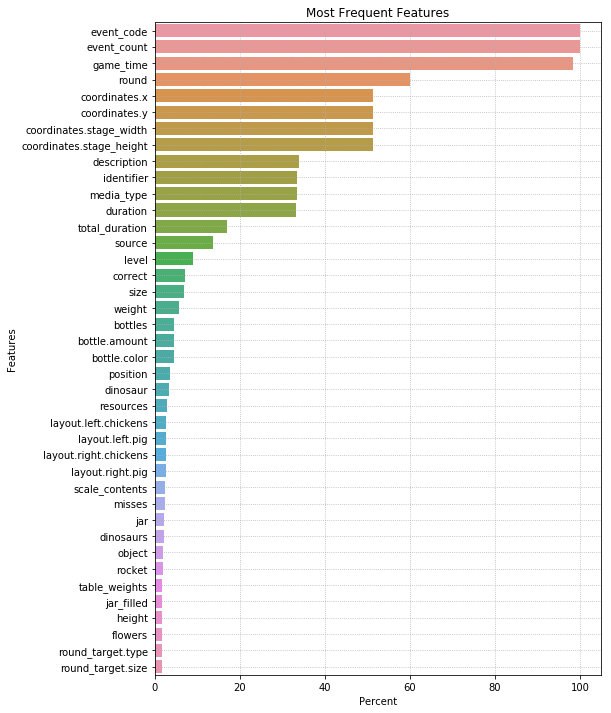

In [157]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(8, 12))
ax = sns.barplot(x='Percent', y='index', data=stat_info.head(40))
ax.set_title('Most Frequent Features')
ax.set_ylabel('Features')
ax.grid(True, linestyle='dotted')

In [171]:
freq_keys = stat_info['index'][stat_info['Percent'] >= 5.].tolist()

In [172]:
freq_keys

['event_code',
 'event_count',
 'game_time',
 'round',
 'coordinates.x',
 'coordinates.y',
 'coordinates.stage_width',
 'coordinates.stage_height',
 'description',
 'identifier',
 'media_type',
 'duration',
 'total_duration',
 'source',
 'level',
 'correct',
 'size',
 'weight']

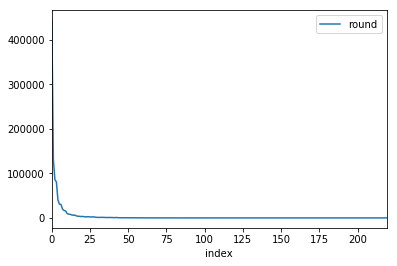

In [246]:
round_df = event_data['round'].fillna(0).value_counts().reset_index()
round_df['index'] = round_df['index'].astype(int)
round_df.sort_values(by='index', inplace=True)
round_df.plot(x='index', y='round')

In [251]:
np.isnan(event_data['coordinates.x'].iloc[3])

True

In [248]:
event_data['coordinates.x'].fillna(0)

0         954.0
1         393.0
2           0.0
3           0.0
4           0.0
          ...  
999995    910.0
999996    752.0
999997    646.0
999998      0.0
999999    337.0
Name: coordinates.x, Length: 1000000, dtype: float64

In [266]:
event_data['media_type'].fillna('unknown').value_counts()

unknown      665828
animation    222336
audio        111836
Name: media_type, dtype: int64

In [234]:
# round: float with NaNs
# coordinates.(x|y): float with NaNs, but presumably integer
# coordinates.stage_(width|height): float with NaNs, but presumably categorical
#
# description: text messages, try to convert into categoricals?
#     (event_data['description'].fillna('n/a').value_counts()
#      .rename('count').reset_index().rename(columns={'index': 'text'}))
#
# identifier: some string, probably concatenated with commas; most simple is to compute len
# event_data['identifier'].fillna('n/a').str.split(',').apply(len)
#
# media_type: categorical string
# event_data['media_type'].fillna('n/a').value_counts()
#
# duration: should already exist in the features set
# total_duration: probably also present in the features
#
# source: also some kind of categorical string
# event_data['source'].fillna('n/a').value_counts()
#
# level: integer feature, can be used as a cumulative metric (?)
# event_data['level'].fillna('n/a').value_counts()
#
# correct: defines if attempt was done, is already used in feature processing
# 
# size: integer feature
# event_data['size'].fillna('n/a').value_counts()
#
# weight: one more integer feature
# event_data['weight'].fillna('n/a').value_counts()

## Features Selection

In [21]:
# selector = selection.FeatureSelection(
#     rules=[
#         ('nonzero', selection.non_zero_rows_and_cols),
#         # ('uncorr', selection.non_correlated_cols),
#     ],
#     ignore_cols=[
#         'accuracy_group', 
#         'installation_id', 
#         'game_session'
#     ]
# )

# if U.on_kaggle():
#     U.log('Loading relevant features list from disk.')
#     features = bundle.features()
# else:
#     U.log('Deriving relevant features from train dataset.')
#     features = selector.select(X_trn)
#     bundle.save(features, 'features')

Deriving relevant features from train dataset.
Excluding from consideration: ['accuracy_group', 'installation_id', 'game_session']
Applying feature selection rule: nonzero
Selected features: 935 of 950
Keeping only features, selected by every rule.
Final number of features changed from 950 to 935


In [52]:
if U.on_kaggle():
    U.log('Loading relevant features list from disk.')
    features = bundle.features()
else:
    columns = X_trn.columns.tolist()
    cnt_cols = U.starts_with(columns, 'cnt_')
    perf_cols = U.starts_with(columns, 'perf_')
    var_cols = U.starts_with(columns, 'var_')
    user_cols = U.starts_with(columns, 'user_')
    ts_cols = U.starts_with(columns, 'ts_')
    event_cols = U.starts_with(columns, 'event_')
    cat_cols = ['session_title']
    # features = cnt_cols + perf_cols + user_cols + event_cols + var_cols + cat_cols
    feateures = event_cols + cnt_cols + perf_cols + user_cols + var_cols + cat_cols
    bundle.save(features, 'features')
U.log(f'Total number of features: {len(features)}')

Total number of features: 937


## Submission

In [54]:
algo = 'lightgbm'
version = '017'
trainer = EnsembleTrainer(algo=algo, cv_metrics={'cappa': cappa})
fold = GroupKFold(n_splits=5)

if U.on_kaggle():
    U.log('Inference on Kaggle.')
    features = bundle.features()
    bounds = bundle.bounds()
    predicted = inference(X_tst, features, bounds=bounds, model=algo, version=version)
    U.log('Saving predictions on disk.')
    filename = submit(predicted)
    submit_df = pd.read_csv(filename)
    U.log('First 20 submission rows:')
    display(submit_df.head(20))
    
else:
    U.log(f'Training model: {algo}')
    config = get_default_config(algo)
    U.set_nested(config, 'model_params.feature_fraction', 0.8)
    U.set_nested(config, 'model_params.bagging_fraction', 0.75)
    U.set_nested(config, 'model_params.bagging_freq', 1)
    result = trainer.train(X_trn, features=features, fold=fold, config=config)
    U.log('Saving the trained models')
    bundle.save(result.models, f'models_{algo}_{version}')
    U.log('Saving the optimal rounding bounds')
    bounds = optimize_rounding_bounds(result.oof, X_trn['accuracy_group'].values)
    U.log(f'Optimal bounds: {bounds}')
    bundle.save(bounds, 'bounds')

Training model: lightgbm
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.03162	val's rmse: 1.04612
[200]	trn's rmse: 0.948825	val's rmse: 0.977912
[300]	trn's rmse: 0.903814	val's rmse: 0.948351
[400]	trn's rmse: 0.874081	val's rmse: 0.932974
[500]	trn's rmse: 0.851309	val's rmse: 0.924476
[600]	trn's rmse: 0.832607	val's rmse: 0.920518
[700]	trn's rmse: 0.81622	val's rmse: 0.918172
[800]	trn's rmse: 0.801088	val's rmse: 0.916785
[900]	trn's rmse: 0.786954	val's rmse: 0.916075
[1000]	trn's rmse: 0.773531	val's rmse: 0.915483
[1100]	trn's rmse: 0.761038	val's rmse: 0.914943
[1200]	trn's rmse: 0.749289	val's rmse: 0.914984
Early stopping, best iteration is:
[1108]	trn's rmse: 0.760083	val's rmse: 0.914838
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.02753	val's rmse: 1.05452
[200]	trn's rmse: 0.945993	val's rmse: 0.986801
[300]	trn's rmse: 0.902642	val's rmse: 0.957303
[40

In [ ]:
# if U.on_kaggle():
#     U.log('Inference on Kaggle.')
#     features = bundle.features()
#     bounds = bundle.bounds()
#     predicted = inference(X_tst, features, bounds=bounds, model=algo, version=version)
#     U.log('Saving predictions on disk.')
#     filename = submit(predicted)
#     submit_df = pd.read_csv(filename)
#     U.log('First 20 submission rows:')
#     display(submit_df.head(20))
    
# else:
#     U.log('Training with sub-optimal rounding.')
#     reg_metric = RegressionCappa([-np.inf, 1., 2., 3., +np.inf])
#     result = train(X_trn, features, reg_metric, algo=algo)
    
#     U.log('Using predictions to find optimal rounding boundaries.')
#     opt_bounds = optimize_rounding_bounds(result.oof, X_trn['accuracy_group'].values)
#     U.log(f'Optimal values: {opt_bounds}')
    
#     U.log('Using optimal boundaries to train a new ensemble of models.')
#     reg_metric = RegressionCappa(opt_bounds)
#     result = train(X_trn, features, reg_metric, algo=algo)
    
#     U.log('Saving the final results.')
#     bundle.save(result.models, f'models_{algo}_{version}')
#     bundle.save(opt_bounds, 'bounds')

In [55]:
if not U.on_kaggle():
    import os
    features = bundle.features()
    bounds = bundle.bounds()
    filename = submit(inference(X_tst, features, bounds, model=algo, version=version))
    assert os.path.exists(filename)
    assert pd.read_csv(filename).shape[0] == 1000
    bundle.package(folder='/home/ck/data/bowl2019/external/')

Running inference on dataset of shape: 937
Loading external models: lightgbm v017.
Running models on test data...
Averaging ensemble predictions.
Rounding predictions using optimal bounds.
Converting predictions into submission file.
Running locally.
(1000, 2) Packaging training results into dataset.
/tmp/bowl2019/meta.joblib --> /home/ck/data/bowl2019/external/meta.joblib
/tmp/bowl2019/models_lightgbm_017.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_017.joblib
/tmp/bowl2019/models_lightgbm_016.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_016.joblib
/tmp/bowl2019/bounds.joblib --> /home/ck/data/bowl2019/external/bounds.joblib
/tmp/bowl2019/features.joblib --> /home/ck/data/bowl2019/external/features.joblib
/tmp/bowl2019/encoders.joblib --> /home/ck/data/bowl2019/external/encoders.joblib
Packaging helper scripts into dataset.
../selection.py --> /home/ck/data/bowl2019/external/selection.py
../encode.py --> /home/ck/data/bowl2019/external/encode.py
../features

In [56]:
pd.read_csv('submission.csv')['accuracy_group'].value_counts()

2    323
3    313
1    184
0    180
Name: accuracy_group, dtype: int64